In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

In [2]:
# Install PySpark
!pip install pyspark

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("RetailStore_MLlib") \
    .getOrCreate()

# Verify Spark session
print(spark.version)

3.5.4


In [5]:
# Load the dataset from Google Drive
file_path = '/content/drive/MyDrive/retailstore_large.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Display the schema and sample data
df.printSchema()
df.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Country: string (nullable = true)

+----------+----+------+------+-------+
|CustomerID| Age|Salary|Gender|Country|
+----------+----+------+------+-------+
|         1|18.0| 20000|  Male|Germany|
|         2|19.0| 22000|Female| France|
|         3|20.0| 24000|Female|England|
|         4|21.0|  2600|  Male|England|
|         5|22.0| 50000|  Male| France|
+----------+----+------+------+-------+
only showing top 5 rows



In [6]:
from pyspark.sql.functions import col, sum

# Count nulls in each column
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----------+---+------+------+-------+
|CustomerID|Age|Salary|Gender|Country|
+----------+---+------+------+-------+
|         0|  0|     0|     0|      0|
+----------+---+------+------+-------+



In [7]:
df.count()


1048575

In [8]:
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
country_indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex")
df = gender_indexer.fit(df).transform(df)
df = country_indexer.fit(df).transform(df)


In [9]:
feature_columns = ['Age', 'Salary', 'GenderIndex', 'CountryIndex']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

In [10]:
kmeans = KMeans(featuresCol='features', k=3)  # Adjust k as needed
kmeans_model = kmeans.fit(df)
cluster_centers = kmeans_model.clusterCenters()

In [11]:
print("Cluster Centers: ")
for center in cluster_centers:
    print(center)

Cluster Centers: 
[5.51811018e+01 5.74999553e+04 4.81012809e-01 8.12512294e-01]
[5.51804836e+01 1.34500252e+04 4.80996261e-01 8.12509686e-01]
[5.51809803e+01 3.82665912e+04 4.81022597e-01 8.12492549e-01]


In [12]:
# Add cluster predictions to the DataFrame
df = kmeans_model.transform(df)
df.select("CustomerID", "features", "prediction").show(5)

+----------+--------------------+----------+
|CustomerID|            features|prediction|
+----------+--------------------+----------+
|         1|[18.0,20000.0,0.0...|         1|
|         2|[19.0,22000.0,1.0...|         1|
|         3|[20.0,24000.0,1.0...|         1|
|         4|[21.0,2600.0,0.0,...|         1|
|         5|[22.0,50000.0,0.0...|         0|
+----------+--------------------+----------+
only showing top 5 rows



In [13]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Evaluate clustering using Silhouette Score
evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='prediction', metricName='silhouette')
silhouette = evaluator.evaluate(df)
print(f"Silhouette Score: {silhouette:.2f}")


Silhouette Score: 0.82


In [15]:
# Rename the 'prediction' column from KMeans to avoid conflict
df = df.withColumnRenamed("prediction", "cluster_prediction")

df = df.withColumn("label", (df["Salary"] > 40000).cast("int"))


# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Apply Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

In [16]:
predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Logistic Regression Model Accuracy: {accuracy:.2f}")

# Show sample predictions
predictions.select("Age", "Salary", "Gender", "prediction").show(10)

# Save classification results to a CSV (optional)
predictions.select("CustomerID", "prediction").write.csv("/path_to_output/classification_results.csv", header=True)

Logistic Regression Model Accuracy: 1.00
+-----------+------+------+----------+
|        Age|Salary|Gender|prediction|
+-----------+------+------+----------+
|       20.0| 24000|Female|       0.0|
|       24.0|  4300|  Male|       0.0|
|       35.0| 35000|  Male|       0.0|
|35.14545455|  7600|  Male|       0.0|
|43.43636364| 42000|Female|       1.0|
|48.96363636| 12600|Female|       0.0|
|57.25454545| 47000|  Male|       1.0|
|65.54545455| 50000|Female|       1.0|
|       35.0| 30000|Female|       0.0|
|       27.0| 32000|Female|       0.0|
+-----------+------+------+----------+
only showing top 10 rows



In [17]:
# Evaluate using Precision, Recall, and F1-Score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print(f"Weighted Precision: {precision:.2f}")

recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(f"Weighted Recall: {recall:.2f}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1-Score: {f1_score:.2f}")


Weighted Precision: 1.00
Weighted Recall: 1.00
F1-Score: 1.00


+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    0|       0.0|134368|
|    1|       1.0| 75363|
+-----+----------+------+



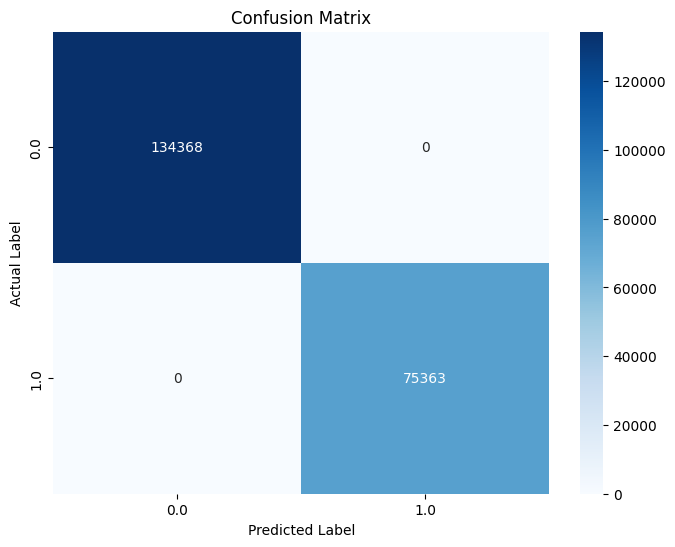

In [18]:
# Generate confusion matrix in PySpark
confusion_matrix = predictions.groupBy("label", "prediction").count()
confusion_matrix.show()

# Convert to Pandas for easier visualization
pdf = predictions.select("label", "prediction").toPandas()

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix using sklearn
cm = confusion_matrix(pdf['label'], pdf['prediction'])

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr_model.summary.labels, yticklabels=lr_model.summary.labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()


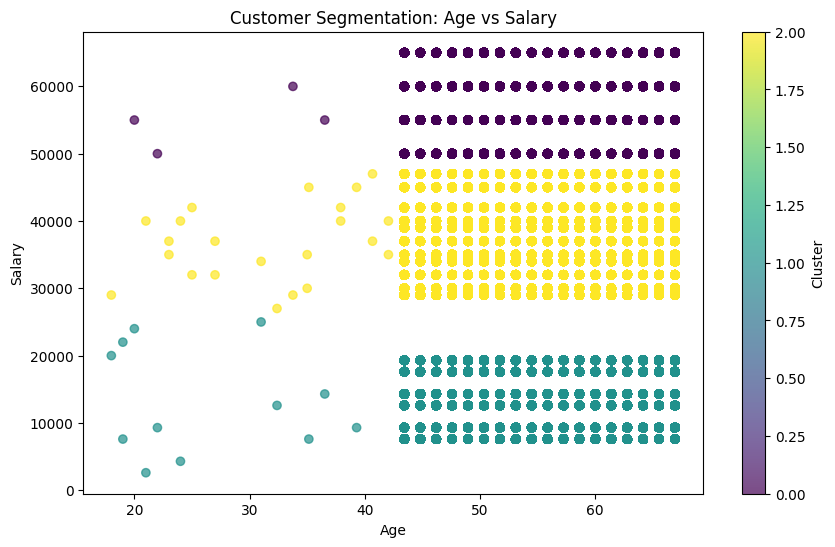

In [19]:
# Convert data for visualization
pdf = df.select("Age", "Salary", "cluster_prediction").toPandas() # Changed 'prediction' to 'cluster_prediction'

# Scatter plot for clustering
plt.figure(figsize=(10, 6))
plt.scatter(pdf["Age"], pdf["Salary"], c=pdf["cluster_prediction"], cmap="viridis", alpha=0.7) # Changed 'prediction' to 'cluster_prediction'
plt.colorbar(label="Cluster")
plt.xlabel("Age")
plt.ylabel("Salary")
plt.title("Customer Segmentation: Age vs Salary")
plt.show()

In [24]:
# Visualization 1: Gender-wise Salary Distribution by Country

<ipython-input-21-1c34723c72d0>:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(data=pdf, x="Country", y="Salary", hue="Gender", split=True, scale="count", inner="quartile", palette="muted")


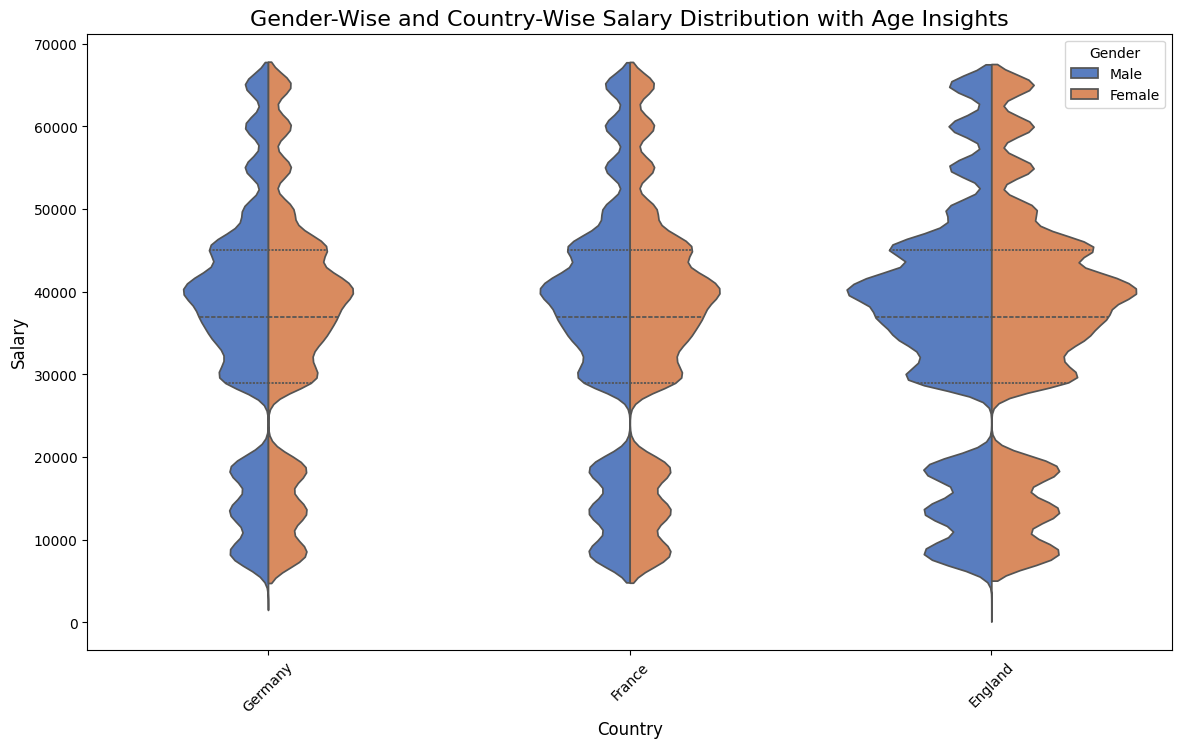

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the Spark DataFrame to Pandas
pdf = df.select("Gender", "Country", "Salary", "Age").toPandas()

# Create age groups for better visualization
pdf['AgeGroup'] = pd.cut(pdf['Age'], bins=[0, 20, 30, 40, 50, 60, 100], labels=["0-20", "21-30", "31-40", "41-50", "51-60", "60+"])

# Create a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(data=pdf, x="Country", y="Salary", hue="Gender", split=True, scale="count", inner="quartile", palette="muted")

# Add labels and title
plt.title("Gender-Wise and Country-Wise Salary Distribution with Age Insights", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Salary", fontsize=12)
plt.xticks(rotation=45)

# Display the plot
plt.legend(title="Gender")
plt.show()


In [ ]:
# Visualization 2: Gender as Main Category with Age and Salary as Subcategories

<ipython-input-22-f8f6794de9d7>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = pdf.groupby(['Gender', 'AgeGroup'])['Salary'].mean().reset_index()


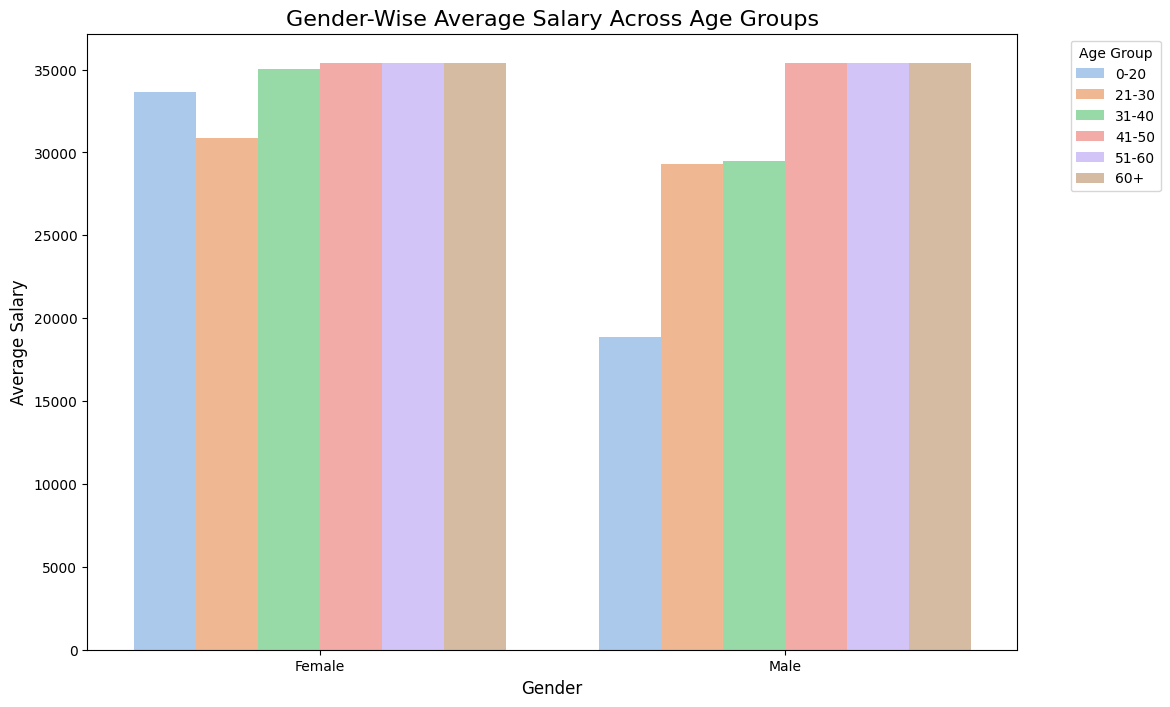

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the Spark DataFrame to Pandas
pdf = df.select("Gender", "Country", "Salary", "Age").toPandas()

# Create age groups for better visualization
pdf['AgeGroup'] = pd.cut(pdf['Age'], bins=[0, 20, 30, 40, 50, 60, 100], labels=["0-20", "21-30", "31-40", "41-50", "51-60", "60+"])

# Calculate average salary for each Gender and AgeGroup
grouped_data = pdf.groupby(['Gender', 'AgeGroup'])['Salary'].mean().reset_index()

# Plot the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(data=grouped_data, x="Gender", y="Salary", hue="AgeGroup", palette="pastel")

# Add labels and title
plt.title("Gender-Wise Average Salary Across Age Groups", fontsize=16)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Average Salary", fontsize=12)

# Adjust the legend
plt.legend(title="Age Group", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


<ipython-input-23-63d41682a412>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_salary = pdf.groupby(['AgeGroup', 'Country'])['Salary'].mean().reset_index()


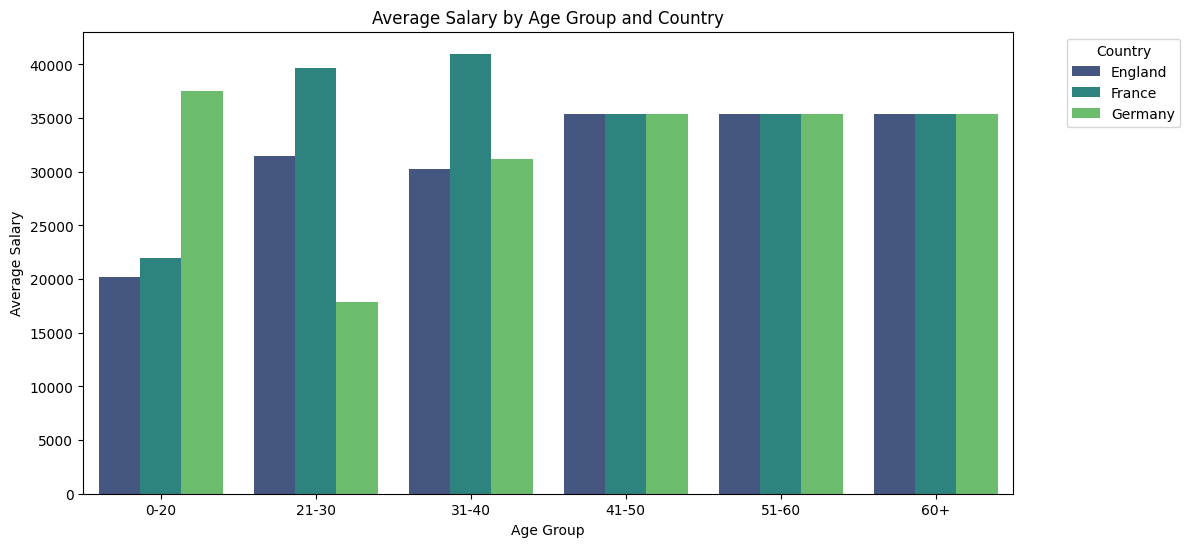

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Recreate pdf with 'Age' column included
pdf = df.select("Gender", "Country", "Salary", "Age").toPandas() # Include 'Age' column

# Add age group column to the DataFrame
pdf['AgeGroup'] = pd.cut(pdf['Age'], bins=[0, 20, 30, 40, 50, 60, 100], labels=["0-20", "21-30", "31-40", "41-50", "51-60", "60+"])

# Calculate average salary by age group and country
age_group_salary = pdf.groupby(['AgeGroup', 'Country'])['Salary'].mean().reset_index()

# Plot the average salary by age group across countries
plt.figure(figsize=(12, 6))
sns.barplot(data=age_group_salary, x='AgeGroup', y='Salary', hue='Country', palette='viridis')
plt.title('Average Salary by Age Group and Country')
plt.xlabel('Age Group')
plt.ylabel('Average Salary')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

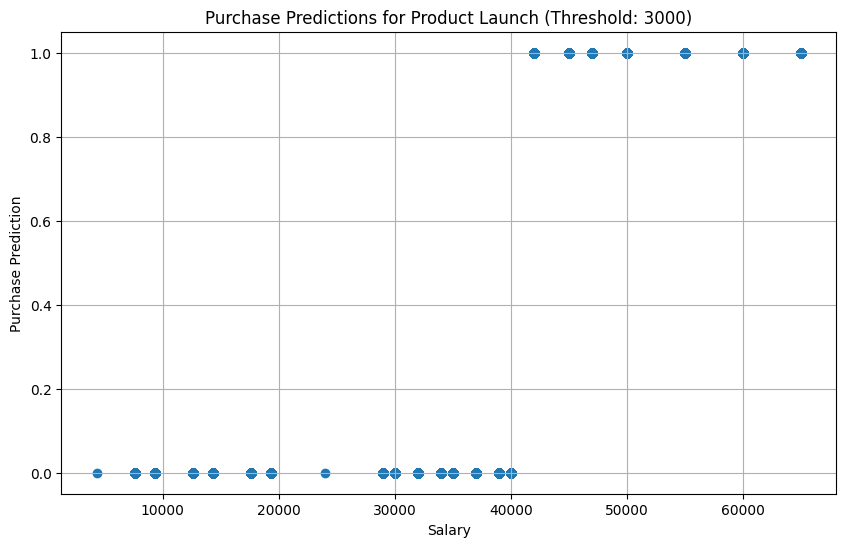

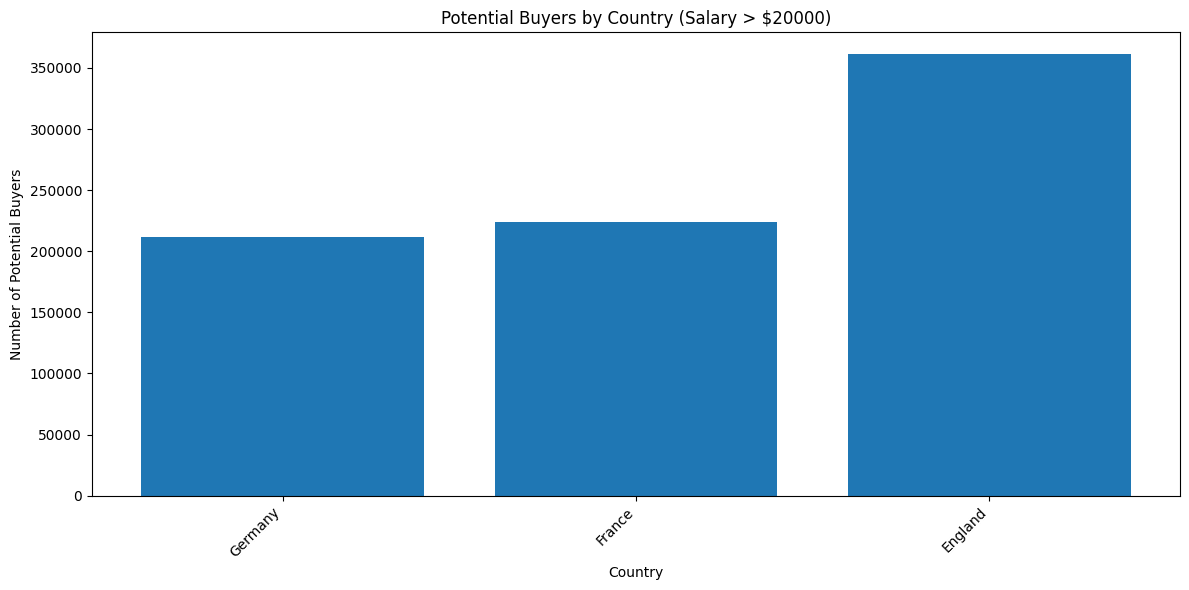

In [26]:
# prompt: give me the visualisation code for predicting if i launch a product of 3000 how many people from the country will gonna buy it based on their salary

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

# Assuming 'predictions' DataFrame from your code is available
# and contains 'Salary' and 'prediction' columns.

# Filter predictions for a product launch of 3000
# Assuming 'prediction' column indicates purchase probability or a similar metric
product_launch_threshold = 3000
# Assuming you have a column in the predictions dataframe that relates to the product
# Replace with the actual product column name if different

# Convert Spark DataFrame to Pandas DataFrame for plotting
pdf = predictions.select("Salary", "prediction").toPandas()

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(pdf["Salary"], pdf["prediction"])
plt.xlabel("Salary")
plt.ylabel("Purchase Prediction")
plt.title(f"Purchase Predictions for Product Launch (Threshold: {product_launch_threshold})")
plt.grid(True)
plt.show()

# Assuming 'df' is your original DataFrame containing 'Salary' and 'Country'
# Calculate potential buyers based on salary threshold (e.g., salary > 40000)
salary_threshold = 20000
potential_buyers = df.filter(df["Salary"] > salary_threshold).groupBy("Country").count()

# Convert to Pandas DataFrame for plotting
potential_buyers_pdf = potential_buyers.toPandas()

# Create a bar plot for potential buyers in each country
plt.figure(figsize=(12, 6))
plt.bar(potential_buyers_pdf["Country"], potential_buyers_pdf["count"])
plt.xlabel("Country")
plt.ylabel("Number of Potential Buyers")
plt.title(f"Potential Buyers by Country (Salary > ${salary_threshold})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()